In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.0 MB/s eta 0:00:00


In [ ]:
import efficientnet.tfkeras as efn  
import librosa
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from efficientnet.keras import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.utils import class_weight
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [ ]:
import pandas as pd

meta_data_cicadidae = pd.read_csv("drive/My Drive/AI4NE/Cicadidae.csv")
meta_data_orthoptera = pd.read_csv("drive/My Drive/AI4NE/Orthoptera.csv")
audio_cicadidae = "drive/My Drive/AI4NE/Audio/Cicadidae"
audio_orthoptera = "drive/My Drive/AI4NE/Audio/Orthoptera"
audio_dir = "drive/My Drive/AI4NE/Audio"

In [ ]:
metadata = pd.concat([meta_data_orthoptera, meta_data_cicadidae])
metadata = metadata[metadata["class_ID"] != 26]
metadata.loc[metadata['class_ID'] == 31, 'class_ID'] = 26


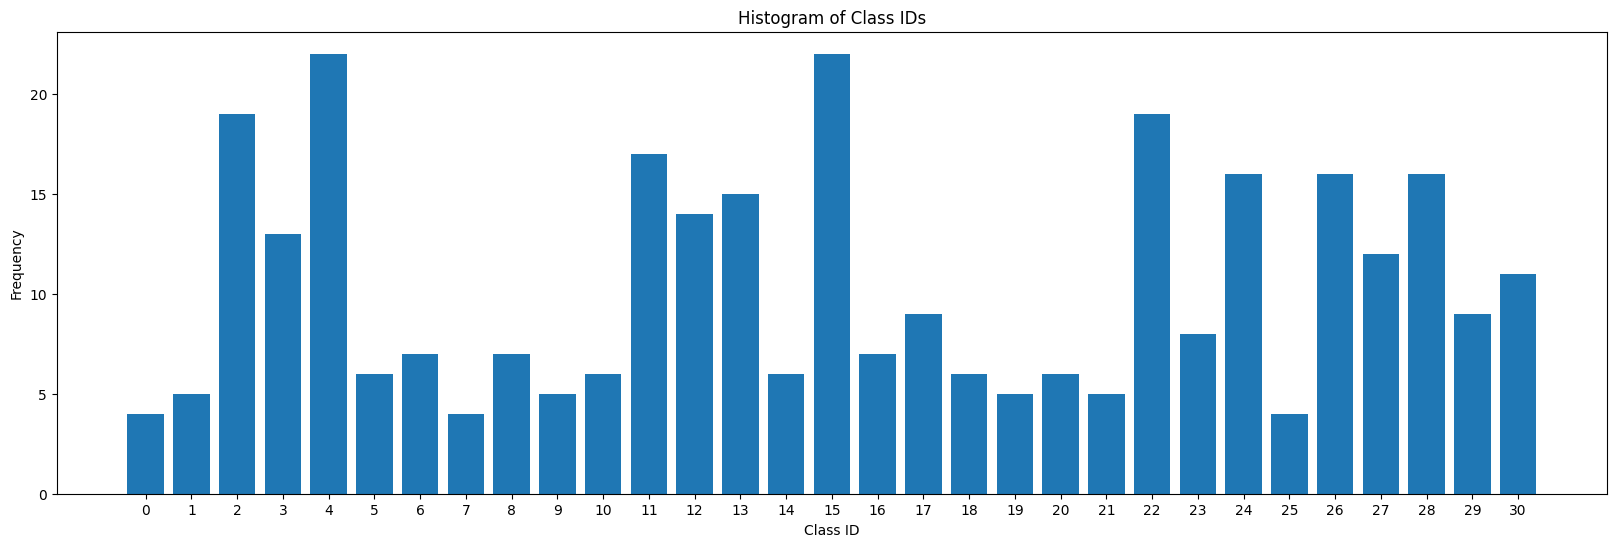

In [ ]:
# histogram of class_ID
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.hist(metadata['class_ID'], bins=range(0, 32), align='left', rwidth=0.8)
plt.xlabel('Class ID')
plt.ylabel('Frequency')
plt.title('Histogram of Class IDs')

plt.xticks(range(0, 31))

plt.show()


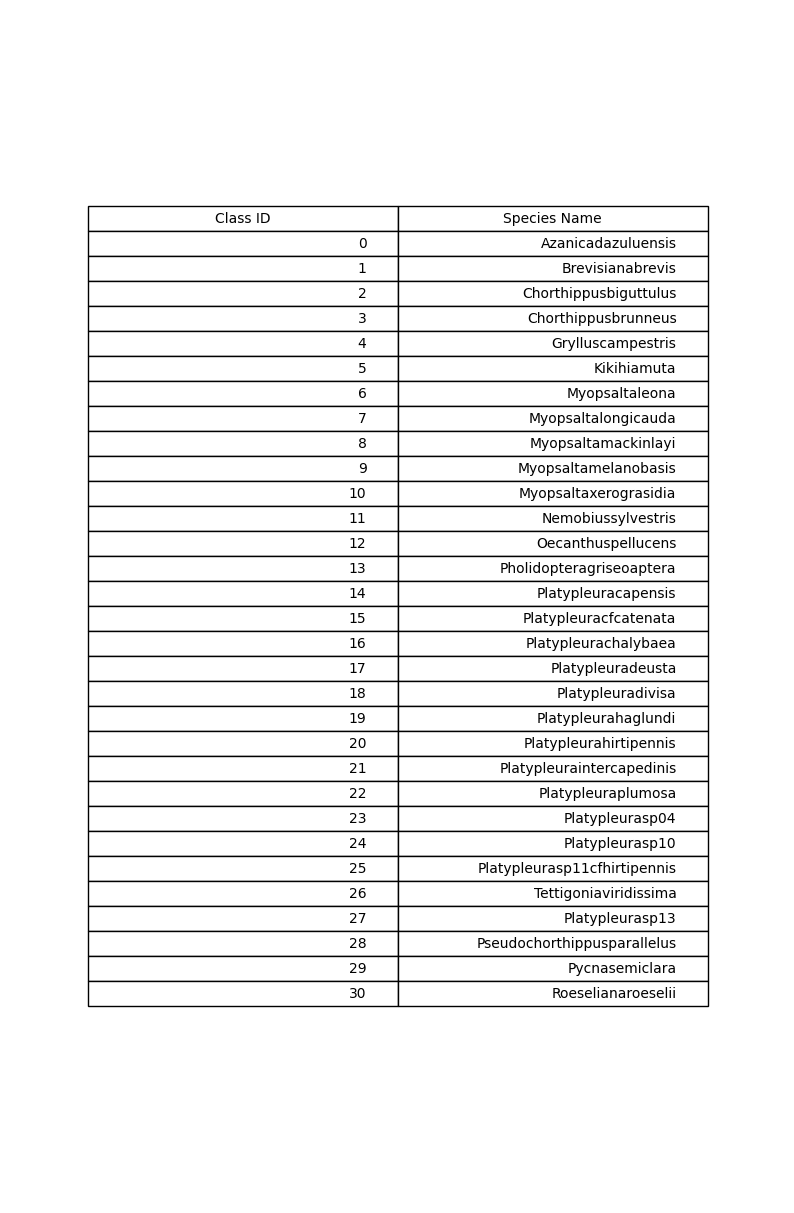

In [ ]:
# mapping of class ID to species name
class_id_to_species = metadata.groupby('class_ID')['species'].first()

# Create the table
fig, ax = plt.subplots(figsize=(10, len(class_id_to_species) / 2))
ax.axis('off')  # Hide axis

table_data = []
for class_id, species_name in class_id_to_species.items():
    table_data.append([class_id, species_name])

table = ax.table(cellText=table_data, colLabels=['Class ID', 'Species Name'], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(0.8, 1.5)

plt.show()

# Preprocessing sample

This sample is meant to show the steps of preprocessing the dataset: segmentation and transformation into mel-spectrograms.

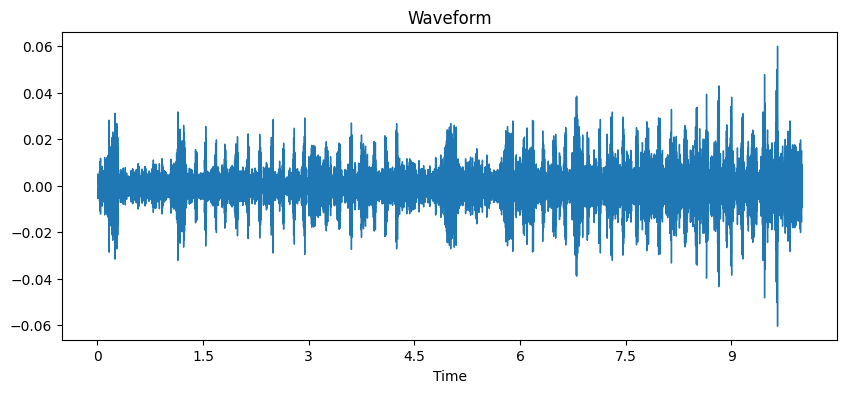

In [ ]:
SOUND_DIR = "drive/My Drive/AI4NE/Audio/Cicadidae/Kikihiamuta/Kikihiamuta_05_Kikihia_muta_North_Island_form.wav"

signal, sr = librosa.load(SOUND_DIR, duration=10)  # sr = sampling rate

# listen to the recording
ipd.display(ipd.Audio(SOUND_DIR))

# plot recording signal
plt.figure(figsize=(10, 4))
librosa.display.waveshow(signal, sr=sr)
plt.title("Waveform")
plt.show()

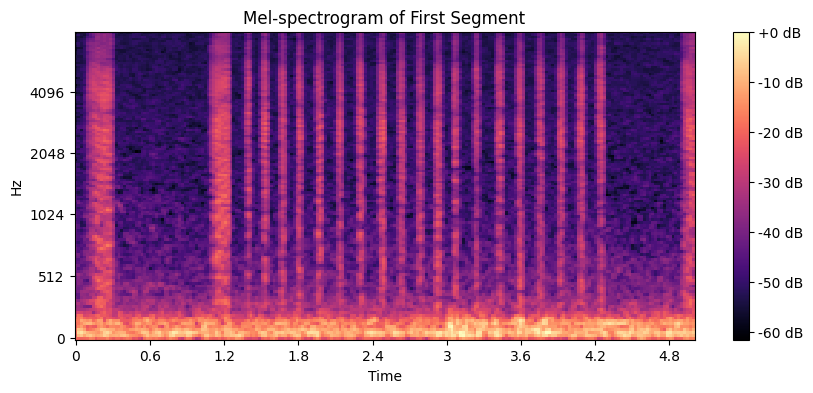

<Figure size 640x480 with 0 Axes>

In [ ]:
segment_duration = 5  
stride = 1  # this is the overlap between segments

signal, sr = librosa.load(SOUND_DIR, duration=10)

segment_samples = int(segment_duration * sr)
stride_samples = int(stride * sr)

# segmentation 
segments = []
for i in range(0, len(signal) - segment_samples + 1, stride_samples):
    segment = signal[i:i + segment_samples]
    segments.append(segment)

first_segment = segments[0]
mel_spectrogram = librosa.feature.melspectrogram(y=first_segment, sr=sr, n_mels=128, fmax=8000)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spectrogram of First Segment')
plt.show()
plt.tight_layout()
plt.show()

# Preprocessing

In [ ]:
def audio_to_mel_segments(audio_file, output_folder, segment_duration=5, stride=1, sr=22050, n_mels=128):
    """
    Segments an audio file into overlapping segments, converts each segment into a mel-spectrogram, and saves them.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    audio, _ = librosa.load(audio_file, sr=sr)

    segment_length = int(segment_duration * sr)
    stride_length = int(stride * sr)

    start = 0
    segment_index = 0
    while start + segment_length <= len(audio):
        segment = audio[start:start + segment_length]

        # spectrograms
        mel_spec = librosa.feature.melspectrogram(y=segment, sr=sr, n_mels=n_mels)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        output_file = os.path.join(output_folder, f"segment_{segment_index:04d}.png")
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f"Mel-Spectrogram Segment {segment_index}")
        plt.tight_layout()
        plt.savefig(output_file)
        plt.close()

        start += stride_length
        segment_index += 1

    print(f"Processing complete. Mel-spectrograms saved in {output_folder}")

In [ ]:
audio_dir = "drive/My Drive/AI4NE/Audio"
segmented_audio_dir = "drive/My Drive/AI4NE/Spectrograms"
num = 0
for family in os.listdir(audio_dir):
    family_path = os.path.join(audio_dir, family)
    for species in os.listdir(family_path):
        species_path = os.path.join(family_path, species)
        for recording in os.listdir(species_path):
            recording_path = os.path.join(species_path, recording)
            if os.path.isfile(recording_path) and recording.lower().endswith(('.wav')):
                audio_to_mel_segments(recording_path, os.path.join(segmented_audio_dir, family, species))



Processing complete. Mel-spectrograms saved in drive/My Drive/AI4NE/Spectograms/Orthoptera/Grylluscampestris
Processing complete. Mel-spectrograms saved in drive/My Drive/AI4NE/Spectograms/Orthoptera/Grylluscampestris
Processing complete. Mel-spectrograms saved in drive/My Drive/AI4NE/Spectograms/Orthoptera/Grylluscampestris
Processing complete. Mel-spectrograms saved in drive/My Drive/AI4NE/Spectograms/Orthoptera/Grylluscampestris
Processing complete. Mel-spectrograms saved in drive/My Drive/AI4NE/Spectograms/Orthoptera/Grylluscampestris
Processing complete. Mel-spectrograms saved in drive/My Drive/AI4NE/Spectograms/Orthoptera/Grylluscampestris
Processing complete. Mel-spectrograms saved in drive/My Drive/AI4NE/Spectograms/Orthoptera/Grylluscampestris
Processing complete. Mel-spectrograms saved in drive/My Drive/AI4NE/Spectograms/Orthoptera/Grylluscampestris
Processing complete. Mel-spectrograms saved in drive/My Drive/AI4NE/Spectograms/Orthoptera/Grylluscampestris
Processing complete

# Convolutional Neural Network

In [ ]:
IM_SIZE = (224, 224, 3)
insects = list(metadata["species"].unique())
DATA_PATH = "drive/My Drive/AI4NE/data"
BATCH_SIZE = 16

Splitting into train, val and test

In [ ]:
import shutil
from sklearn.model_selection import train_test_split
import random
import collections

output_dir = "drive/My Drive/AI4NE/Spectograms"
data_dir = "drive/My Drive/AI4NE/data"

os.makedirs(os.path.join(data_dir, "train"), exist_ok=True)
os.makedirs(os.path.join(data_dir, "val"), exist_ok=True)
os.makedirs(os.path.join(data_dir, "test"), exist_ok=True)

image_data = []
for family in os.listdir(output_dir):
    family_path = os.path.join(output_dir, family)
    for species in os.listdir(family_path):
        species_path = os.path.join(family_path, species)
        for image in os.listdir(species_path):
            image_path = os.path.join(species_path, image)
            image_data.append((image_path, species))  

class_images = collections.defaultdict(list)
for image_path, label in image_data:
    class_images[label].append(image_path)

X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []
for label, images in class_images.items():
    num_val = max(1, int(len(images) * 0.2))  # At least 1 for validation
    num_test = max(1, int(len(images) * 0.2))  # At least 1 for testing
    num_train = len(images) - num_val - num_test

    # Split images for this class
    train_images, temp_images = random.sample(images, num_train), random.sample(images, num_val + num_test)  
    val_images, test_images = random.sample(temp_images, num_val), random.sample(temp_images, num_test)  


    X_train.extend(train_images)
    X_val.extend(val_images)
    X_test.extend(test_images)
    y_train.extend([label] * num_train)
    y_val.extend([label] * num_val)
    y_test.extend([label] * num_test)


# Copy images to suitable directories
def copy_images(image_paths, labels, split_dir):
    for image_path, label in zip(image_paths, labels):
        dst = os.path.join(data_dir, split_dir, label, os.path.basename(image_path))
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(image_path, dst)

copy_images(X_train, y_train, "train")
copy_images(X_val, y_val, "val")
copy_images(X_test, y_test, "test")

print("Data splitting complete.")

Data splitting complete.


Training

In [ ]:
# augmentation of the mel-spectrograms
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode="nearest",
)

train_batches = train_datagen.flow_from_directory(
    DATA_PATH + "/train",
    classes=None,
    target_size=IM_SIZE[:2],
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE,
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_batches = valid_datagen.flow_from_directory(
    DATA_PATH + "/val",
    classes=None,
    target_size=IM_SIZE[:2],
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_batches = test_datagen.flow_from_directory(
    DATA_PATH + "/test",
    classes=None,
    target_size=IM_SIZE[:2],
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

Found 272 images belonging to 31 classes.
Found 78 images belonging to 31 classes.
Found 78 images belonging to 31 classes.


In [ ]:
# CNN
net = efn.EfficientNetB3(
    include_top=False, weights="imagenet", input_tensor=None, input_shape=IM_SIZE
)
x = net.output
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(31, activation="softmax", name="softmax")(x)
net_final = Model(inputs=net.input, outputs=output_layer)
net_final.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)

44107200/44107200 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Estimation of class weights

y_train_int = train_batches.classes.astype(int)

# If y_train_int is empty
if y_train_int.size == 0:
  print("Warning: train_batches.classes is empty. Check data loading.")
  print("DATA_PATH:", DATA_PATH) 
  print("train_batches.classes:", train_batches.classes) 

  num_classes = len(train_batches.class_indices) 
  class_weights = {i: 1.0 for i in range(31)} # equal weights for all classes
else:
  class_weights = class_weight.compute_class_weight(
      class_weight="balanced",
      classes=np.unique(y_train_int),
      y=y_train_int,
  )

# convert to dictionary
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)  

# define callbacks
ModelCheck = ModelCheckpoint(
    "models/efficientnet_checkpoint.weights.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode="auto",
)

ReduceLR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=3e-4)

Class weights: {0: 2.193548387096774, 1: 2.193548387096774, 2: 0.8774193548387097, 3: 0.8774193548387097, 4: 0.5849462365591398, 5: 2.193548387096774, 6: 2.193548387096774, 7: 2.193548387096774, 8: 2.193548387096774, 9: 2.193548387096774, 10: 2.193548387096774, 11: 0.08862821766047572, 12: 0.5849462365591398, 13: 0.7311827956989247, 14: 2.193548387096774, 15: 2.193548387096774, 16: 2.193548387096774, 17: 2.193548387096774, 18: 2.193548387096774, 19: 2.193548387096774, 20: 2.193548387096774, 21: 2.193548387096774, 22: 2.193548387096774, 23: 2.193548387096774, 24: 2.193548387096774, 25: 2.193548387096774, 26: 2.193548387096774, 27: 0.8774193548387097, 28: 2.193548387096774, 29: 0.974910394265233, 30: 2.193548387096774}


In [ ]:
# After training one time, in order to retrain the model, it needs to be recompiled
net_final.compile(
    optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"]
)

In [ ]:
# calculation of steps_per_epoch parameter

train_dir = os.path.join(DATA_PATH, "train")
total_train_samples = sum([len(files) for r, d, files in os.walk(train_dir)])
print("Total training samples:", total_train_samples)
steps_per_epoch = total_train_samples // BATCH_SIZE
print("Calculated steps_per_epoch:", steps_per_epoch)

Total training samples: 272
Calculated steps_per_epoch: 17


In [ ]:
# Train the model
net_final.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=10,
    steps_per_epoch=17,
    class_weight=class_weights,
    callbacks=[ModelCheck, ReduceLR],
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 256s 6s/step - accuracy: 0.1319 - loss: 6.2411 - val_accuracy: 0.4359 - val_loss: 5.6189 - learning_rate: 0.0010
Epoch 2/10


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4359 - val_loss: 5.6189 - learning_rate: 0.0010
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 465ms/step - accuracy: 0.3938 - loss: 6.6188 - val_accuracy: 0.4744 - val_loss: 7.7238 - learning_rate: 0.0010
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4744 - val_loss: 7.7238 - learning_rate: 0.0010
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 351ms/step - accuracy: 0.6318 - loss: 4.2010 - val_accuracy: 0.3590 - val_loss: 7.9400 - learning_rate: 0.0010
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.3590 - val_loss: 7.9400 - learning_rate: 0.0010
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 419ms/step - accuracy: 0.5836 - loss: 2.4459 - val_accuracy: 0.5385 - val_loss: 4.2736 - learning_rate: 3.0000e-04
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.0000e+0

# Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_recall_curve, average_precision_score


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Accuracy
    accuracy = accuracy_score(y_test, y_pred_classes)

    # Precision, Recall, F1 Score
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')

    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

    print(f'Accuracy: {accuracy}')
    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1 Score: {f1}')
    print(f'ROC-AUC: {roc_auc}')

    # Plot Precision-Recall curve
    average_precision = average_precision_score(y_test, y_pred, average="micro")

    plt.figure()
    plt.plot(recall, precision, label='Model (area = {0:0.2f})'.format(average_precision))
    plt.xscale('log')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for the Model')
    plt.legend(loc="lower left")
    plt.show()


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_curve,
    auc,
    roc_auc_score
)
import seaborn as sns

def evaluate(model, X_test, y_test, class_names):
    
    # Get model predictions
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    accuracy = accuracy_score(y_test, y_pred_classes)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred, multi_class="ovr")

    y_test_onehot = np.eye(31)[y_test]

    precision_C, recall_C, _ = precision_recall_curve(y_test_onehot.ravel(), y_pred.ravel())
    average_precision = average_precision_score(y_test_onehot, y_pred, average="micro")

    # Precision-Recall curve
    plt.figure()
    plt.plot(recall_C, precision_C, label='Model (area = {0:0.2f})'.format(average_precision))

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for the Model')
    plt.legend(loc="lower left")
    plt.show()

    # ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(31): 
        fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_onehot.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))

    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'roc_auc': roc_auc
    }

    return metrics


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


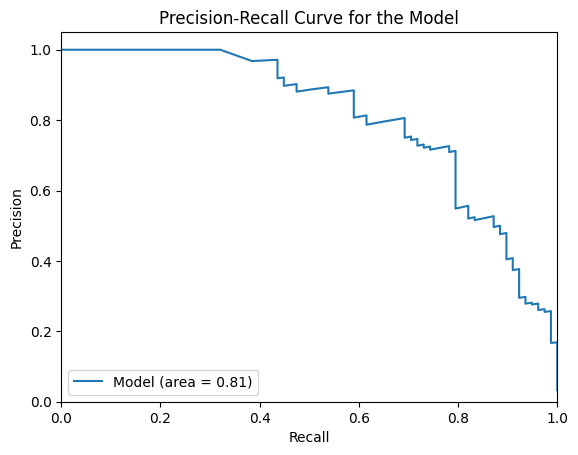

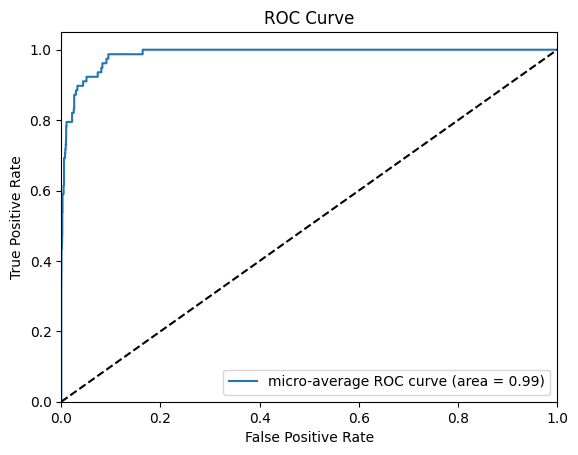

{'accuracy': 0.7307692307692307,
 'precision_weighted': 0.7799145299145299,
 'recall_weighted': 0.7307692307692307,
 'f1_weighted': 0.7252136752136752,
 'roc_auc': {0: 1.0,
  1: 1.0,
  2: 1.0,
  3: 0.9955555555555555,
  4: 0.9808219178082193,
  5: 1.0,
  6: 1.0,
  7: 1.0,
  8: 1.0,
  9: 1.0,
  10: 1.0,
  11: 0.9870923913043479,
  12: 1.0,
  13: 0.9911111111111112,
  14: 1.0,
  15: 1.0,
  16: 1.0,
  17: 1.0,
  18: 1.0,
  19: 1.0,
  20: 1.0,
  21: 0.987012987012987,
  22: 1.0,
  23: 0.974025974025974,
  24: 1.0,
  25: 0.974025974025974,
  26: 1.0,
  27: 1.0,
  28: 1.0,
  29: 1.0,
  30: 1.0,
  'micro': 0.9867110453648916}}

In [ ]:
evaluate(net_final, test_batches, test_batches.classes, insects)